<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this lab, we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for the new classification problem at hand**

TensorFlow Hub is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:
* Use models from TensorFlow Hub with tf.keras.
* Use an image classification model from TensorFlow Hub.
* Do simple transfer learning to fine-tune a model for your own image classes.

# Installs

In [1]:
pip install tensorflow_hub

In [2]:
pip install tf_keras

In [3]:
pip install opencv-python

# Imports

In [4]:
import numpy as np
import cv2
import PIL as PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense

import tf_keras

# An ImageNet classifier


S start by using a classifier model pre-trained on the ImageNet benchmark data. Nt—no initial trainiis ng requirelow.

# Download the classifier

Select a **MobileNetV2 pre-trained model** from **TensorFlow Hub** and wrap it as a Keras layer with `hub.KerasLayer`. Any compatible image classifier model from TensorFlow Hub will work here.

In [5]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

`IMAGE_SHAPE`
:

 This iy a tuple containing the height and width of the images in your dataset. For example, if your images are 224 pixels tall and 224 pixels wide, IMAGE_SHAPE would be (224, 224).

`+(3,)`:

This part adds a third dimension to the IMAGE_SHAPE tuple. This dimension is typically used to represent the number of color channels in the images. For color images, there are 3 channels (red, green, and blue).

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda

# Define your image shape (height, width)
IMAGE_SHAPE = (224, 224)

# Load the pre-trained MobileNet V2 model from TensorFlow Hub
mobilenet_model = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",
    input_shape=IMAGE_SHAPE+(3,),  # Specify input shape with color channels
    trainable=False  # Freeze the pre-trained weights
)

# Create a Sequential model
classifier = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: mobilenet_model.call(x))
])

# Run it on one image

Download one image and try the model on it.

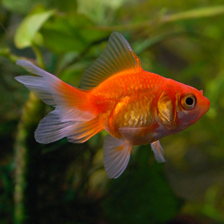

In [8]:
#gold_fish = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/gold_fish.jpg')

gold_fish = Image.open("/content/goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [9]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

#### Add a batch dimension (with np.newaxis) and pass the image to the model:

`np.newaxis`
:

 This is a special value in NumPy that represents a new axis. When used in indexing, it inserts a new dimension into the array at the specified positions.

`...`:

This is called an ellipsis and represents all existing dimensions.

In [10]:
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [11]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with tf.math.argmx:

In [12]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

# Decode the predictions

Take the predicte labelsindexD (such as23) and fetch the ImageNet dataset labels to decode the predictions:

In [13]:
tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = [] # a list

# load image lables from a text file
# This code assumes that the file "ImageNetLabels.txt" contains one label per line.
with open("/content/ImageNetLabels.txt", "r") as f: # with is used to close the file automatically
    image_labels = f.read().splitlines()

image_labels[:5] # print the first five labels

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [14]:
image_labels[predicted_label_index]

'goldfish'

---

# Simple transfer learning

But what iweou want to create a custom classifier usin your own dataset that has classes that a ron't included in the original ImageNet dataset (that the pre-trained model was trained ons dataset:

To do that:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset
Use the TensorFlow flowers dataset:

<h3 style='color:purple'>Load flowers dataset</h3>

In [15]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

# cache_dir indicates where to download data. '.' which means current directory

# untar true will unzip it

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
data_dir

'./datasets/flower_photos'

In [17]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [18]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/tulips/9019694597_2d3bbedb17.jpg'),
 PosixPath('datasets/flower_photos/tulips/7055500907_dcf2bb50e0.jpg'),
 PosixPath('datasets/flower_photos/tulips/8713398114_bc96f1b624_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/16055807744_000bc07afc_m.jpg'),
 PosixPath('datasets/flower_photos/tulips/5388013398_09a8a0f166_m.jpg')]

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [20]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/3451177763_729a4d54af_n.jpg'),
 PosixPath('datasets/flower_photos/roses/1461381091_aaaa663bbe_n.jpg'),
 PosixPath('datasets/flower_photos/roses/18599603859_f2ec616ddf_n.jpg'),
 PosixPath('datasets/flower_photos/roses/4609166128_b7ed49b40b_m.jpg'),
 PosixPath('datasets/flower_photos/roses/4702438868_278b9cf41c_n.jpg')]

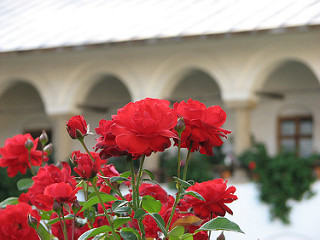

In [21]:
PIL.Image.open(str(roses[1]))

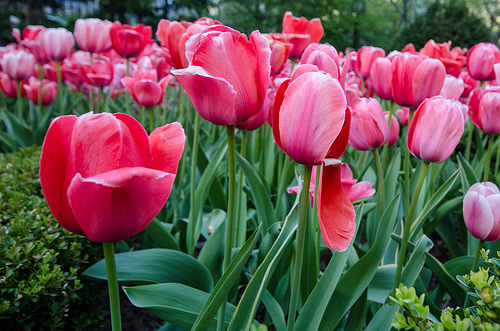

In [22]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [23]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [24]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [25]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/3451177763_729a4d54af_n.jpg'),
 PosixPath('datasets/flower_photos/roses/1461381091_aaaa663bbe_n.jpg'),
 PosixPath('datasets/flower_photos/roses/18599603859_f2ec616ddf_n.jpg'),
 PosixPath('datasets/flower_photos/roses/4609166128_b7ed49b40b_m.jpg'),
 PosixPath('datasets/flower_photos/roses/4702438868_278b9cf41c_n.jpg')]

In [26]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/3451177763_729a4d54af_n.jpg'

In [27]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [28]:
img.shape

(240, 320, 3)

In [29]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [30]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread( str(image) )
        if img is not None:
            resized_img = cv2.resize(img, (224, 224))
            X.append(resized_img)
            y.append(flowers_labels_dict[flower_name])
        else:
            print(f"Error reading image: {image}")
            continue

In [31]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [33]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [34]:
X[0].shape

(224, 224, 3)

In [35]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [36]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

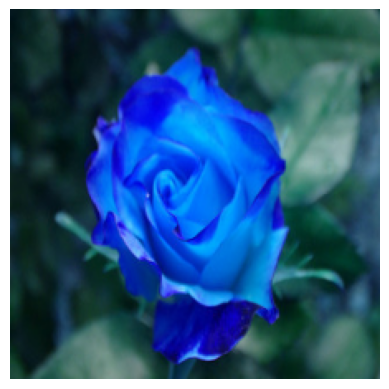

In [37]:
plt.axis('off')
plt.imshow(X[0])

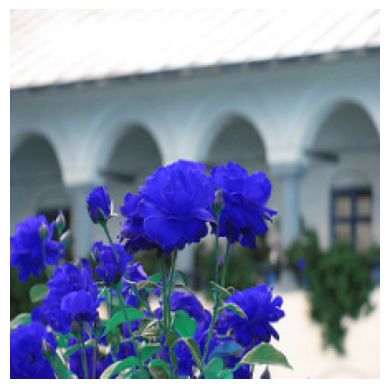

In [38]:
plt.axis('off')
plt.imshow(X[1])

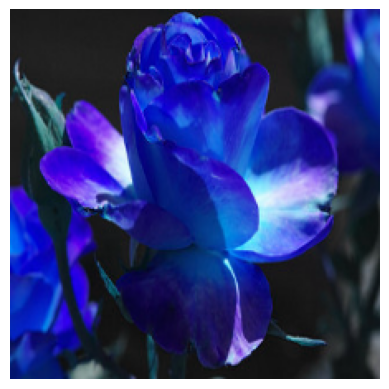

In [39]:
plt.axis('off')
plt.imshow(X[2])

In [40]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([795, 795, 795])

In [41]:
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [42]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [44]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

feature_extractor_model = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

num_of_flowers = 5

# Wrap the hub.KerasLayer in a tf.keras.layers.Lambda layer
model = tf.keras.Sequential([
   tf.keras.layers.Lambda(lambda x: pretrained_model_without_top_layer(x)), # Use the pretrained model as a callable within Lambda
   tf.keras.layers.Dense(num_of_flowers)
])

# Get the pre-trained model's parameters
pretrained_model_params = pretrained_model_without_top_layer.trainable_weights
print(pretrained_model_params)

# Print the parameters
for param in pretrained_model_params:
    print(param.shape)

model.summary()

[]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

# Pre-trained InceptionV3 feature extractor model from TensorFlow Hub
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

# Load the pre-trained model without the top classification layer
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

num_of_flowers = 5  # Number of output classes

# Define the model using the Sequential API
model = tf.keras.Sequential([
    # Lambda layer to call the pre-trained model
    tf.keras.layers.Lambda(lambda x: pretrained_model_without_top_layer(x)),  # Lambda call 1
    # Add a second Lambda layer with another call to the pre-trained model (as requested)
    tf.keras.layers.Lambda(lambda x: pretrained_model_without_top_layer(x)),  # Lambda call 2
    # Add a final Dense layer for classification
    tf.keras.layers.Dense(num_of_flowers)
])

# Get the pre-trained model's parameters
pretrained_model_params = pretrained_model_without_top_layer.trainable_weights
print(pretrained_model_params)  # Should print an empty list because `trainable=False`

# Print the shapes of the parameters (if any)
for param in pretrained_model_params:
    print(param.shape)

# Print a summary of the model
model.summary()


[]


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_16 (Lambda)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_17 (Lambda)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - acc: 0.5514 - loss: 1.3329
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - acc: 0.8133 - loss: 0.4942
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - acc: 0.8624 - loss: 0.3960
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - acc: 0.8881 - loss: 0.3330
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - acc: 0.8998 - loss: 0.2948


In [46]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - acc: 0.8074 - loss: 0.6493


[0.5425094366073608, 0.8213507533073425]

In [47]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

In [48]:
test_image_path = 'sun.jpg'

test_image = preprocess_image(test_image_path)
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class}")

# Example class names (should match your dataset structure)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(f"Predicted flower: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
Predicted class: [3]
Predicted flower: sunflowers


feature extraction inception v3
